## Оганян Роберт. Задание по временным рядам

### Загрузка данных

In [104]:
!pip install plotly pandas statsmodels scikit-learn tqdm

  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)

[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests

from plotly import __version__
print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)

5.13.1


In [2]:
import matplotlib.pyplot as plt

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
     

In [4]:
df = pd.read_csv('./data.csv')
my_data = df[df['ФИО'] == 'Оганян Роберт Владимирович']
title = my_data.Title
index = my_data.index
my_data

,ФИО,Title,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,2021-03-01,...,2023-03-05,2023-03-06,2023-03-07,2023-03-08,2023-03-09,2023-03-10,2023-03-11,2023-03-12,2023-03-13,2023-03-14
23,Оганян Роберт Владимирович,Функция Гудермана,8,17,20,23,17,12,27,22,...,17,16,10,11,15,18,9,16,22,10


In [5]:
my_data = my_data.T.iloc[2:]
my_data.reset_index(inplace=True)
my_data.rename(columns={index.to_numpy()[0]:'Views', 'index':'Date'}, inplace=True)
my_data.Date = pd.to_datetime(my_data.Date)
my_data['Views'] = my_data['Views'].astype(int)
my_data

,Date,Views
0,2021-02-22,8
1,2021-02-23,17
2,2021-02-24,20
3,2021-02-25,23
4,2021-02-26,17
...,...,...
746,2023-03-10,18
747,2023-03-11,9
748,2023-03-12,16
749,2023-03-13,22


Наш ряд имеет следующий вид

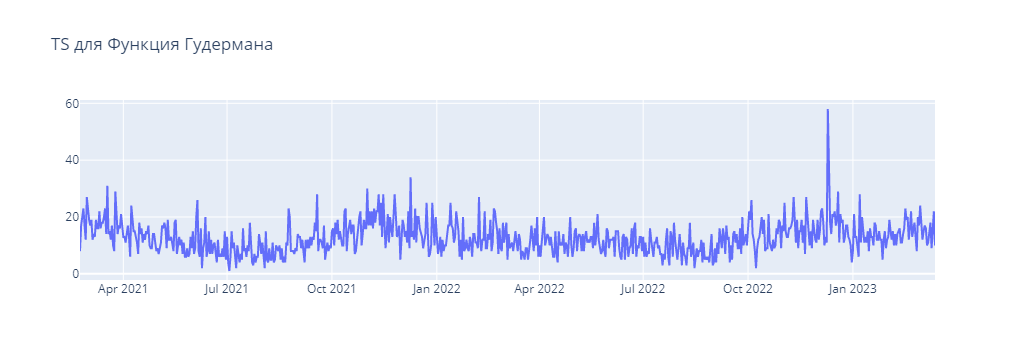

In [6]:
plotly_df(my_data.set_index('Date'), title=f'TS для {str(title.iloc[0])}')

В данных присутствует *индивидуальное* аномальное значение (точка аномальна по отношению ко всем данным, а не к контексту)

### Обработка аномальности

Выявим аномальные точки с помощью скользящего среднего. Будем использовать *оффлайн* версию (аномальность точки выявляется по всей истории. Онлайн версия - история до заданного момента времени)

In [7]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    return anomalies

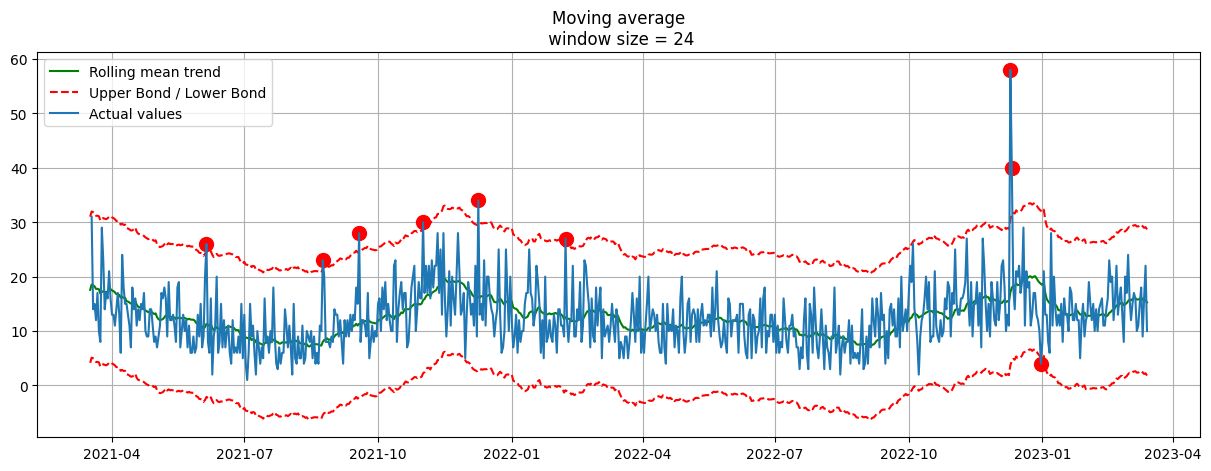

In [9]:
anomalies = plotMovingAverage(
    my_data.set_index('Date'), 24, plot_intervals=True, plot_anomalies=True
)  # daily smoothing

In [10]:
anomalies[anomalies.Views.notna()]

,Views
Date,
2021-06-05,26.0
2021-08-24,23.0
2021-09-18,28.0
2021-11-01,30.0
2021-12-09,34.0
2022-02-07,27.0
2022-12-10,58.0
2022-12-11,40.0
2022-12-31,4.0


Именно выброс здесь в 2022-12-10 и 2022-12-11. Заменим их на значения предыдущего года

In [11]:
my_data.loc[my_data.Date == '2022-12-10', 'Views'] = my_data.loc[my_data.Date == '2021-12-10', 'Views'].values[0]

In [12]:
my_data.loc[my_data.Date == '2022-12-11', 'Views'] = my_data.loc[my_data.Date == '2021-12-11', 'Views'].values[0]

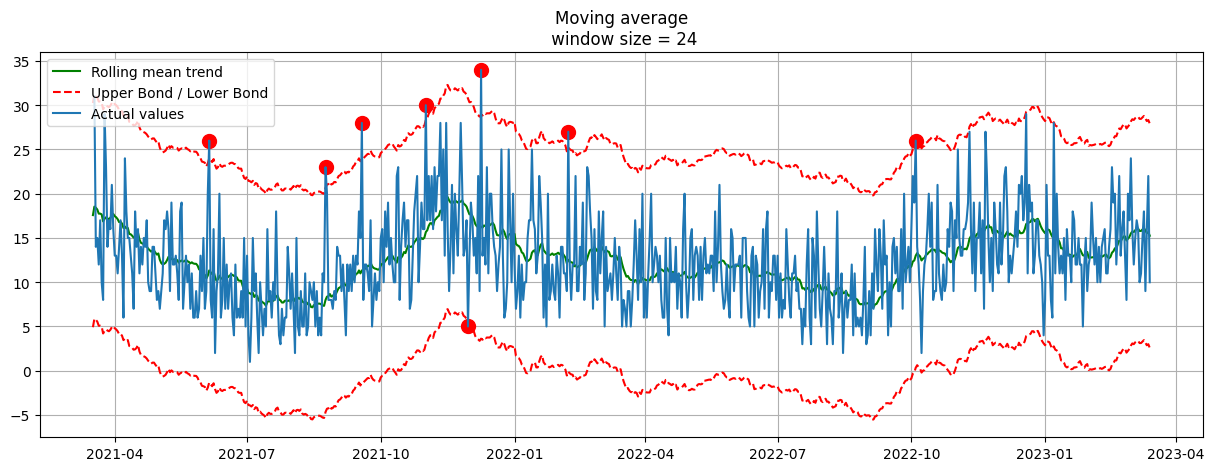

In [13]:
anomalies = plotMovingAverage(
    my_data.set_index('Date'), 24, plot_intervals=True, plot_anomalies=True
)  # daily smoothing

### Приведение ряда к стационарному виду

In [15]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Сначала рассмотрим декомпозицию ряда

Критерий Дики-Фуллера: p=0.043803


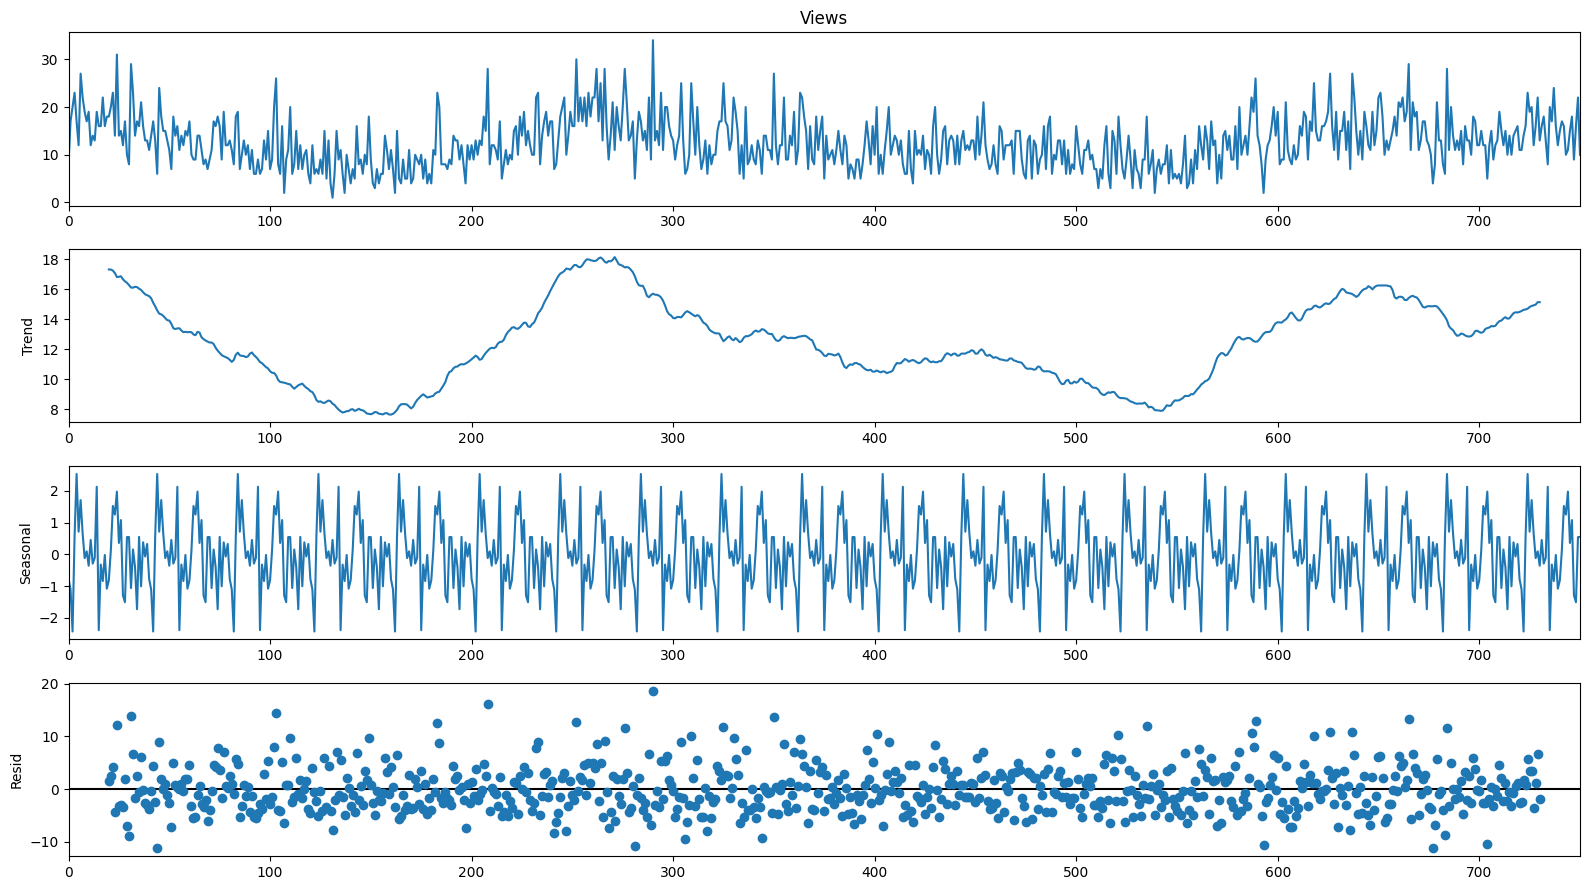

In [32]:
def decomposition(ts, period):
    decomp_viz = sm.tsa.seasonal_decompose(ts, period=period)
    fig = decomp_viz.plot()
    fig.set_size_inches((16, 9))
    fig.tight_layout()
    plt.show()
    
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(my_data['Views'])[1])
decomposition(my_data['Views'], period=40)

Декомпозиция - разложения ряда на 3 компоненты:
1. Тренд - плавное долгосрочное изменение временного ряда
2. Сезонность - циклические изменения временного ряда с постоянным периодом сезонности s
3. Ошибка - непрогнозируемая случаемая величина

В широком смысле, ряд стационарен, если:
1. Дисперсия не зависит от времени (колебания не растут со временем)
2. Математическое ожидание не зависит от времени (в среднем значение ряда постоянно)
3. Корреляция между a и b такая же, как и между a+t и b+t

Гляда на ряд кажется, что он стационарен (также выполняется критерий дики-фуллера). Но это не так. У нашего ряда есть тренд (возрастает и убывает) и сезонность (потом для предсказания будем брать модели, учитывающие сезонность).

In [34]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.043803


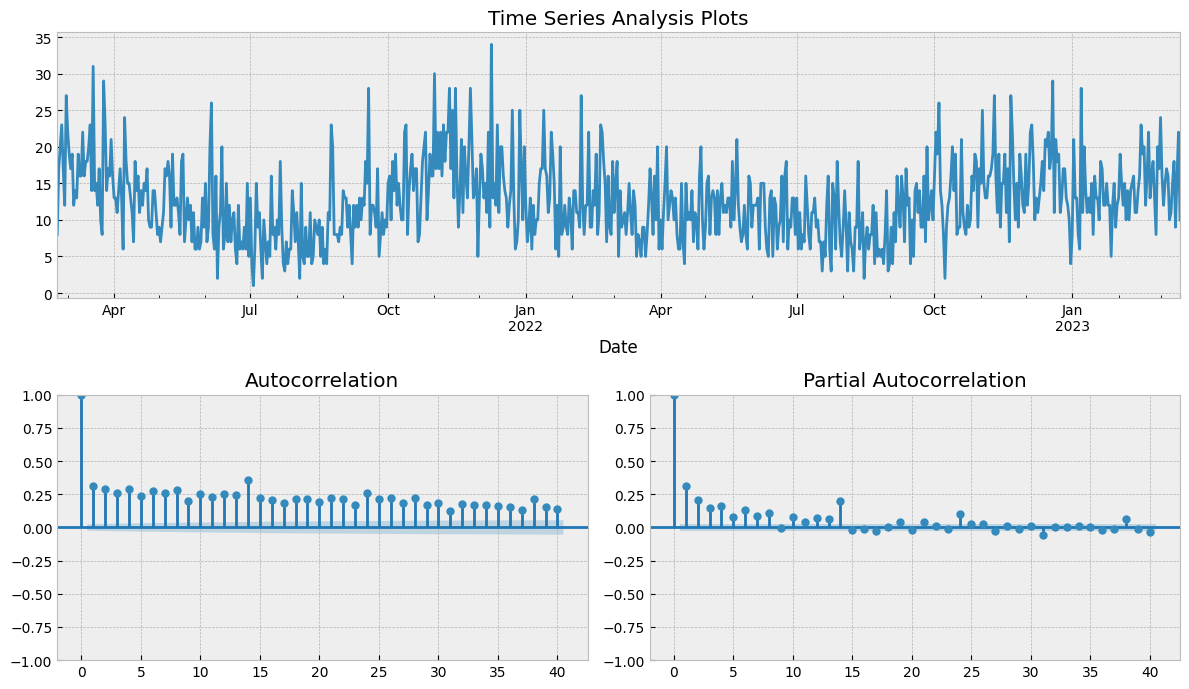

In [35]:
tsplot(my_data.set_index('Date').Views, lags=40)

Также мы получаем слишком много значащих лагов. Попробуем привести ряд к стационарности

In [42]:
from copy import deepcopy
data = deepcopy(my_data)

##### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.5019208080998496
Критерий Дики-Фуллера: p=0.043803


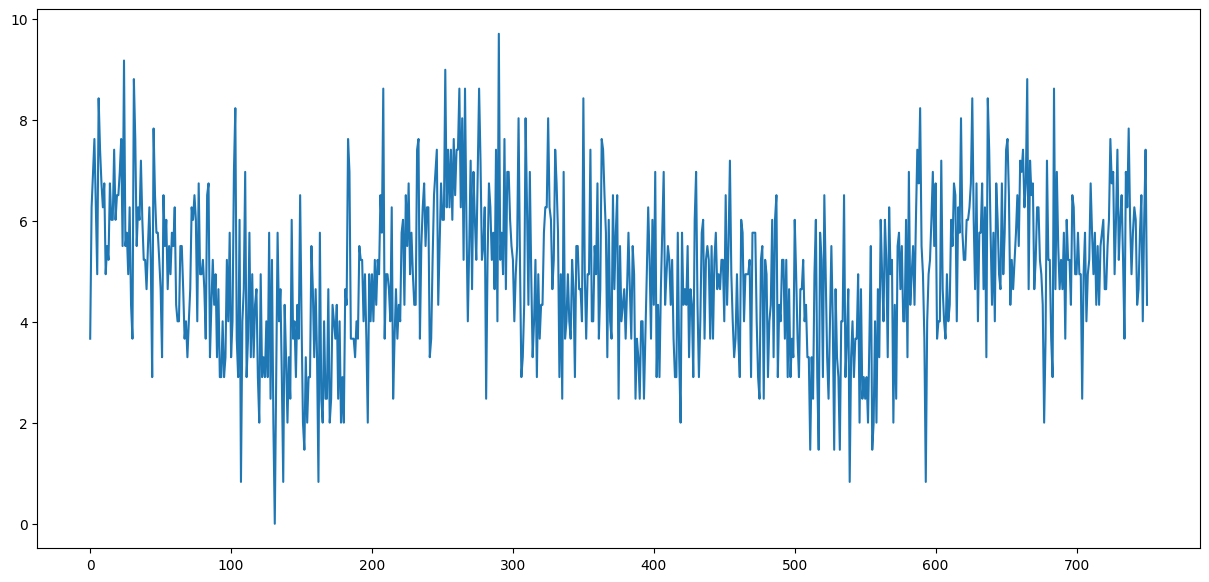

In [63]:
from scipy import stats
import statsmodels.api as sm
data['Box'], lambda_ = stats.boxcox(data.set_index('Date').Views)
plt.figure(figsize=(15,7))
plt.plot(data.Box)
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lambda_}")
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Views)[1])

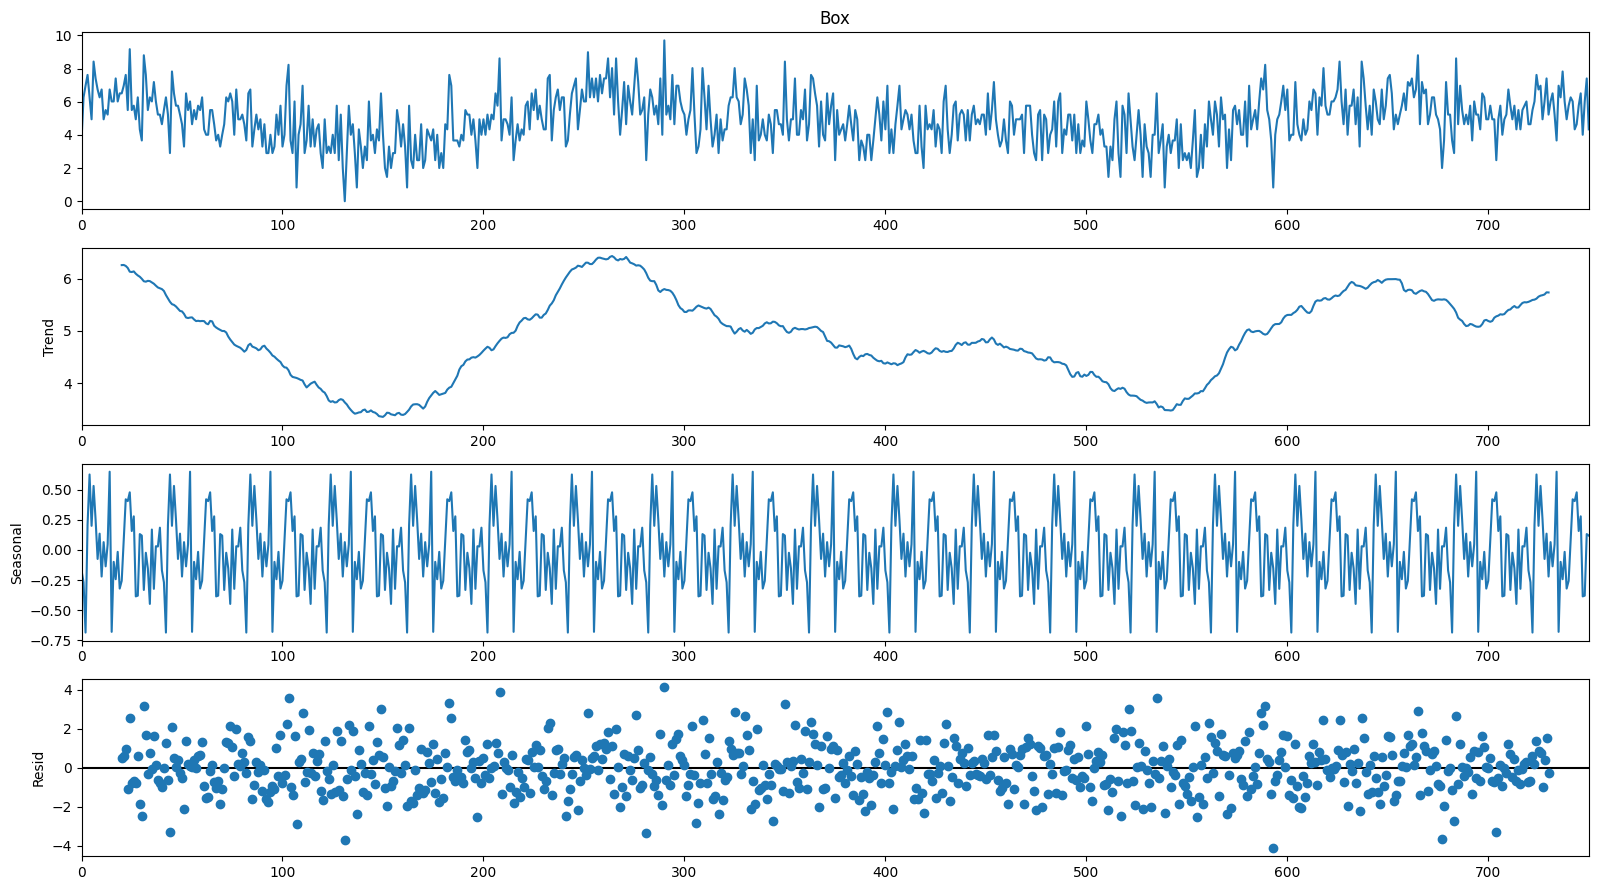

In [64]:
decomposition(data['Box'], period=40)

Ничего не изменилось, ну и ладно

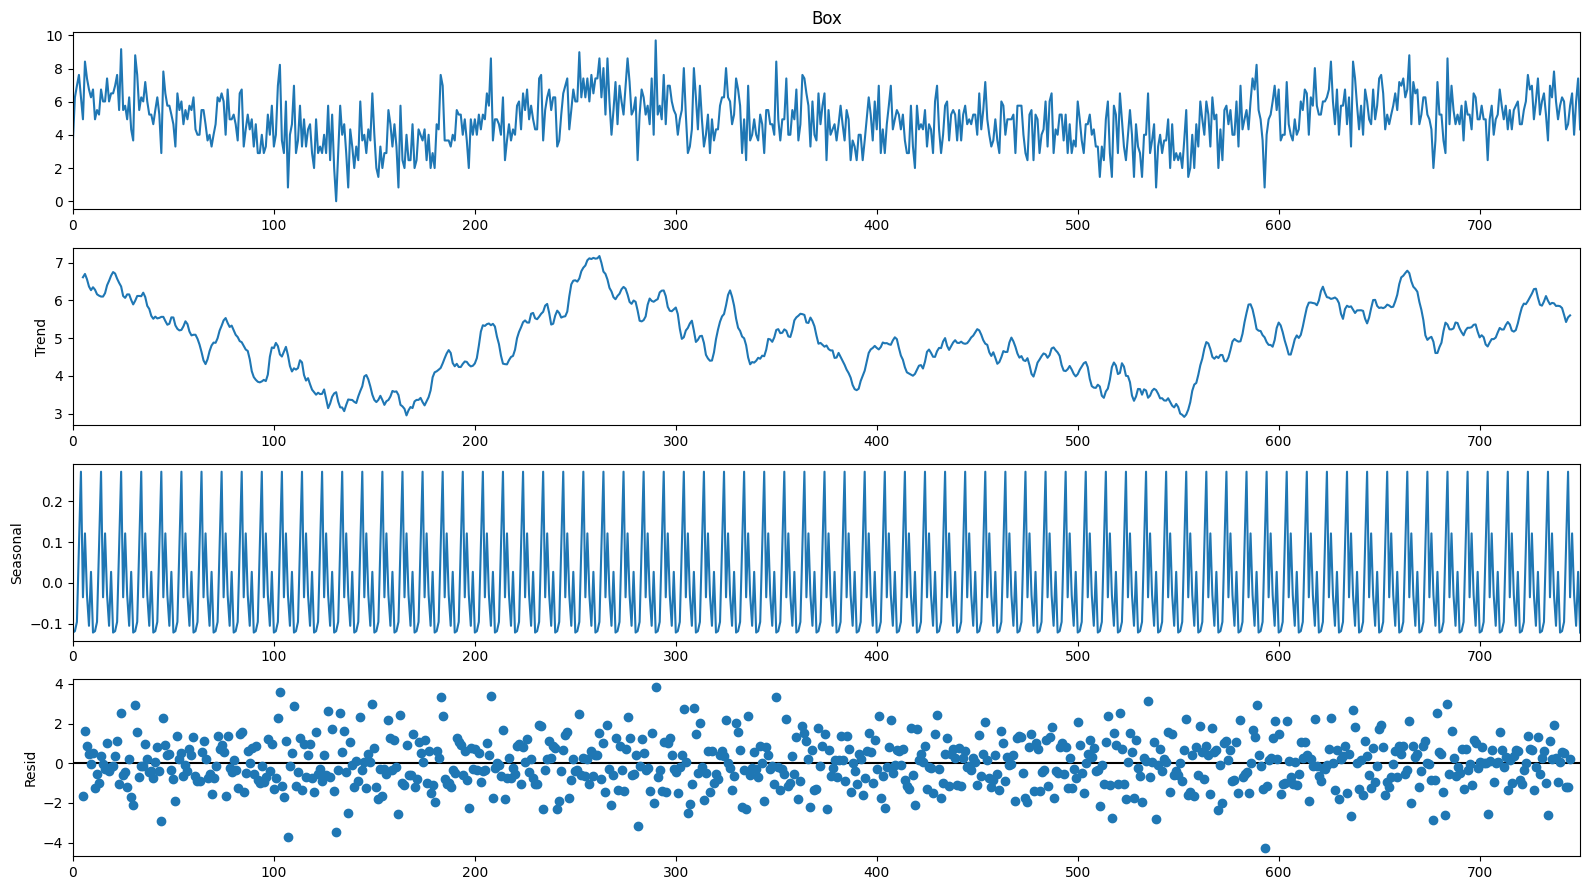

In [65]:
decomposition(data['Box'], period=10)

##### Дифференцирование сезонности & тренда

Для этого вычтем ряд из самого себя с "лагом", равным сезонному периоду (12).

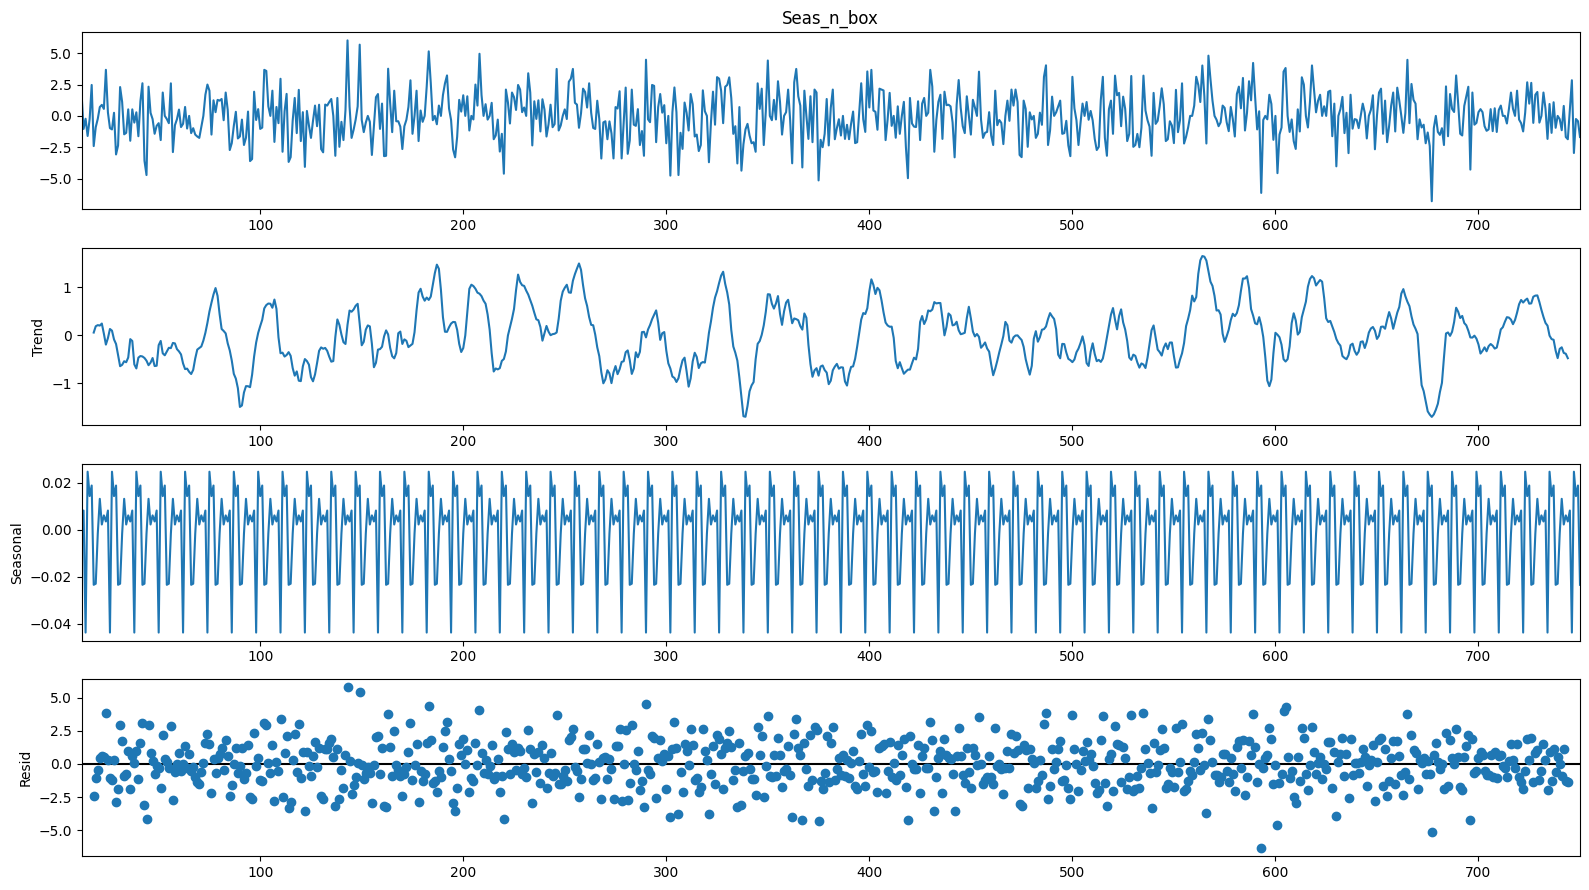

In [93]:
s = 12
data['Seas_n_box'] = data.Box - data.Box.shift(s)
decomposition(data.Seas_n_box[s:], period=s)

Критерий Дики-Фуллера: p=0.000000


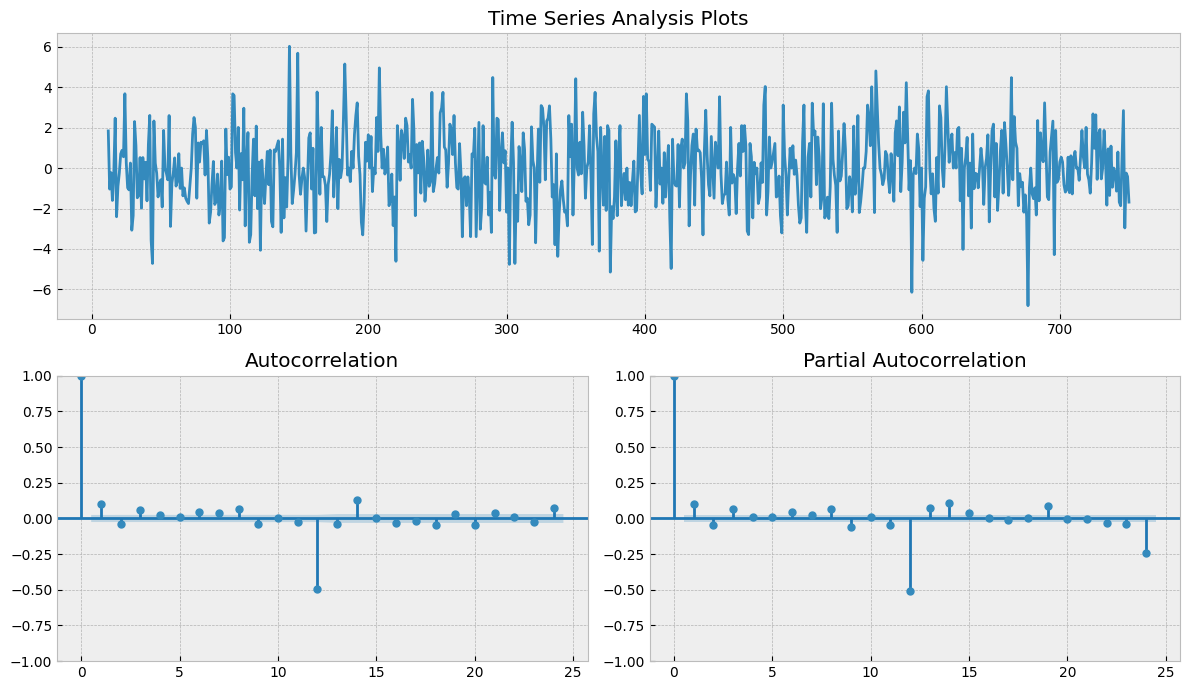

In [94]:
tsplot(data.Seas_n_box[s:], lags=24)

Критерий Дики-Фуллера выполнен; тренд перестал возрастать (просто колеблется); мат.ожидание не меняется со временем; стало меньше значащих лагов в автокорреляции; сезонность сделали циклом => получили стационарный ряд

### Подбор параметров и обучение модели

Нам подойдет модель Sarima, так как есть сезонность

Критерий Дики-Фуллера: p=0.000000


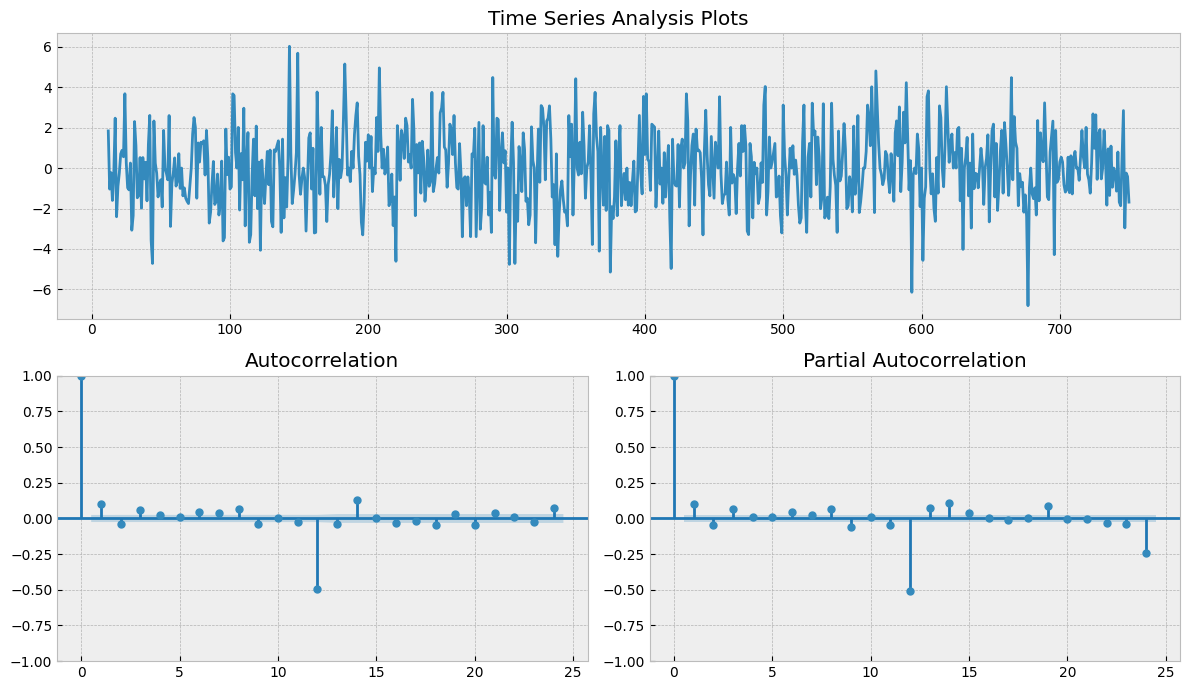

In [96]:
tsplot(data.Seas_n_box[12:], lags=24)

По лекции ШАДа и мфти (https://www.youtube.com/watch?v=u433nrxdf5k) выбирать надо так:

По графику автокорреляции:

Q - номер последнего значимого сезонного лага - 2 (т.к 24)

q - номер последнего значимого несезонного лага - 21

По графику частичной автокорреляции:

P - аналогично 2

p - аналогично 19

s = 12, длина сезона

d = 1, порядок дифференцирования

Однако в статьях, которые вы скидывали, строят графики, затем без обооснования берут какие-то странные начальные приближения и перебирают вокруг них параметры. Например, у них также p аналогично мог быть равен 22, но они пишут, что он равен 3. В общем, я не понял этот момент и хотел бы получить фидбек.

Тогда буду перебирать по аналогии

In [108]:
d=1 
D = 1
s = 12

In [109]:
ps = range(3, 6)
qs = range(3, 6)
Ps = range(0, 2)
Qs = range(0, 2)

In [110]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [111]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(data['Seas_n_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [06:49<00:00, 11.39s/it]

CPU times: user 15min 31s, sys: 11min 44s, total: 27min 15s
Wall time: 6min 49s


In [112]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
23  (4, 5, 1, 1)  2994.361994
15  (4, 3, 1, 1)  2996.855117
3   (3, 3, 1, 1)  2999.713869
7   (3, 4, 1, 1)  3009.065786
19  (4, 4, 1, 1)  3011.508361


In [191]:
p, q, P, Q = result_table1.parameters[0]

In [127]:
best_model2=sm.tsa.statespace.SARIMAX(data['Views'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Views   No. Observations:                  751
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 12)   Log Likelihood               -2401.129
Date:                             Sun, 26 Mar 2023   AIC                           4816.258
Time:                                     23:38:05   BIC                           4848.486
Sample:                                          0   HQIC                          4828.686
                                             - 751                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8511      0.039    -21.821      0.000      -0.928      -0.775
ar.L2         -0.7944      

Полученная модель должна быть несмещенной. Это проверяется критерием Стьюдента

Критерий Стьюдента: p=0.358479
Критерий Дики-Фуллера: p=0.000000


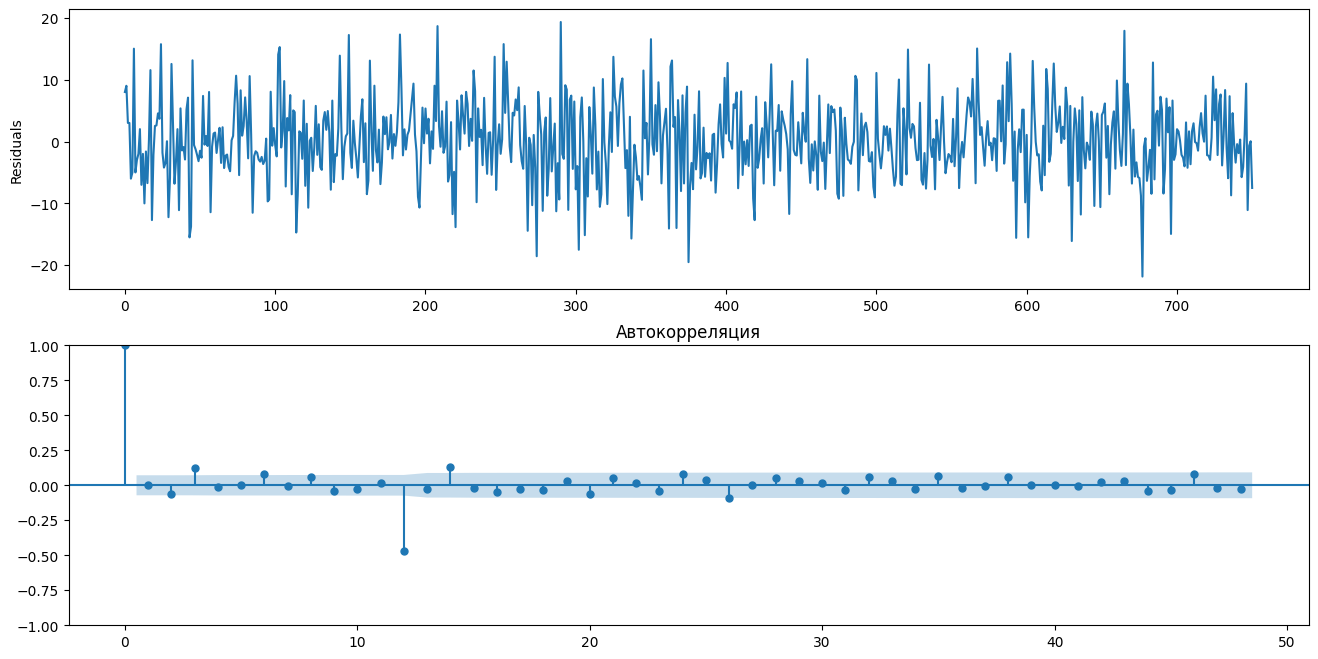

In [128]:
plt.figure(figsize=(16,8))
plt.subplot(211)
best_model2.resid[:].plot() 
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model2.resid[:].values.squeeze(), ax=ax, title='Автокорреляция', lags=48)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model2.resid[:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model2.resid[:])[1])

Критерий получился не очень(

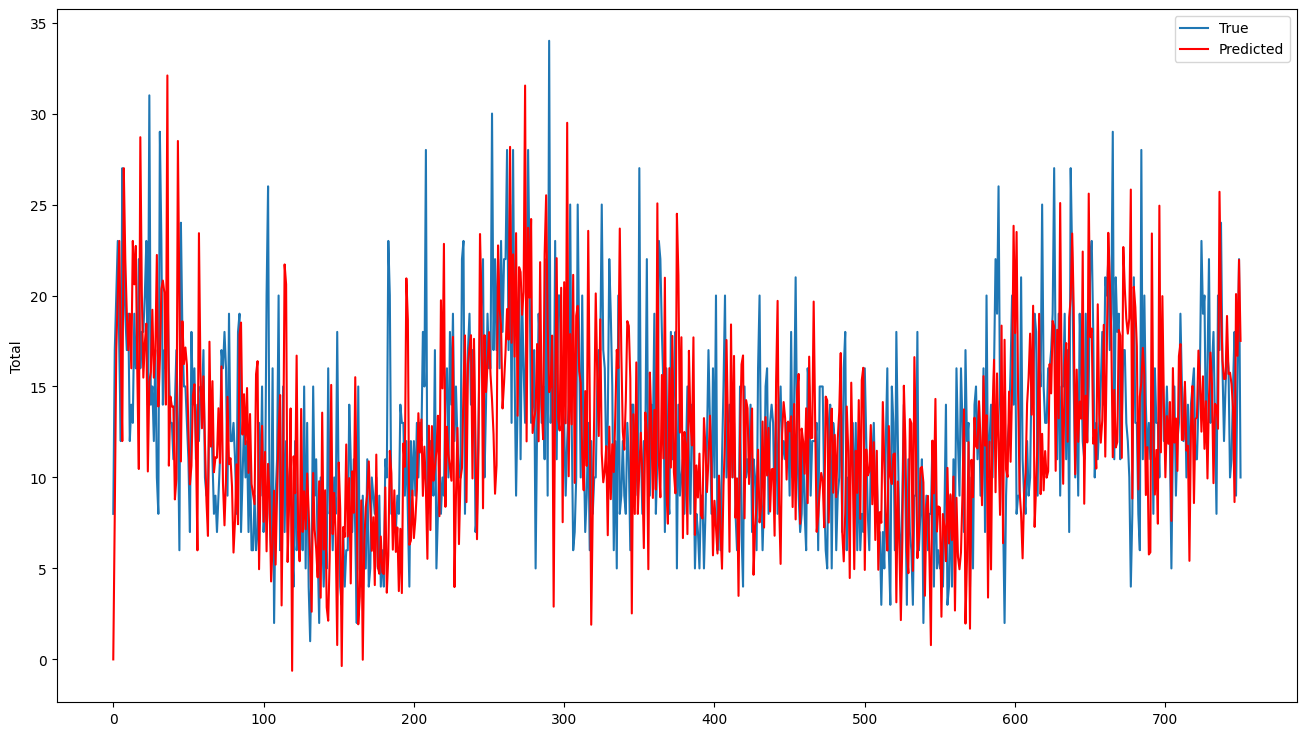

In [132]:
data['Pred'] = best_model2.fittedvalues
plt.figure(figsize=(16,9))
data['Views'].plot(label='True')
data.Pred.plot(color='r', label='Predicted')
plt.ylabel('Total')
plt.legend()
plt.show()

In [188]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_predictions(df, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted model
        n_steps - number of steps to predict in the future
    """
    data = df.copy()
    data.columns = ['Views']
    data['arima_model'] = model.fittedvalues

    # forecast values
    data['arima_model'][:s+d] = np.NaN
    forecast = data['arima_model'].append(model.forecast(n_steps))

    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['Views'][s+d:-n_steps], data['arima_model'][s+d:-n_steps])

    plt.figure(figsize=(20, 10))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="Predicted")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.Views, label="True", alpha=0.8)
    plt.legend()
    plt.grid(True)

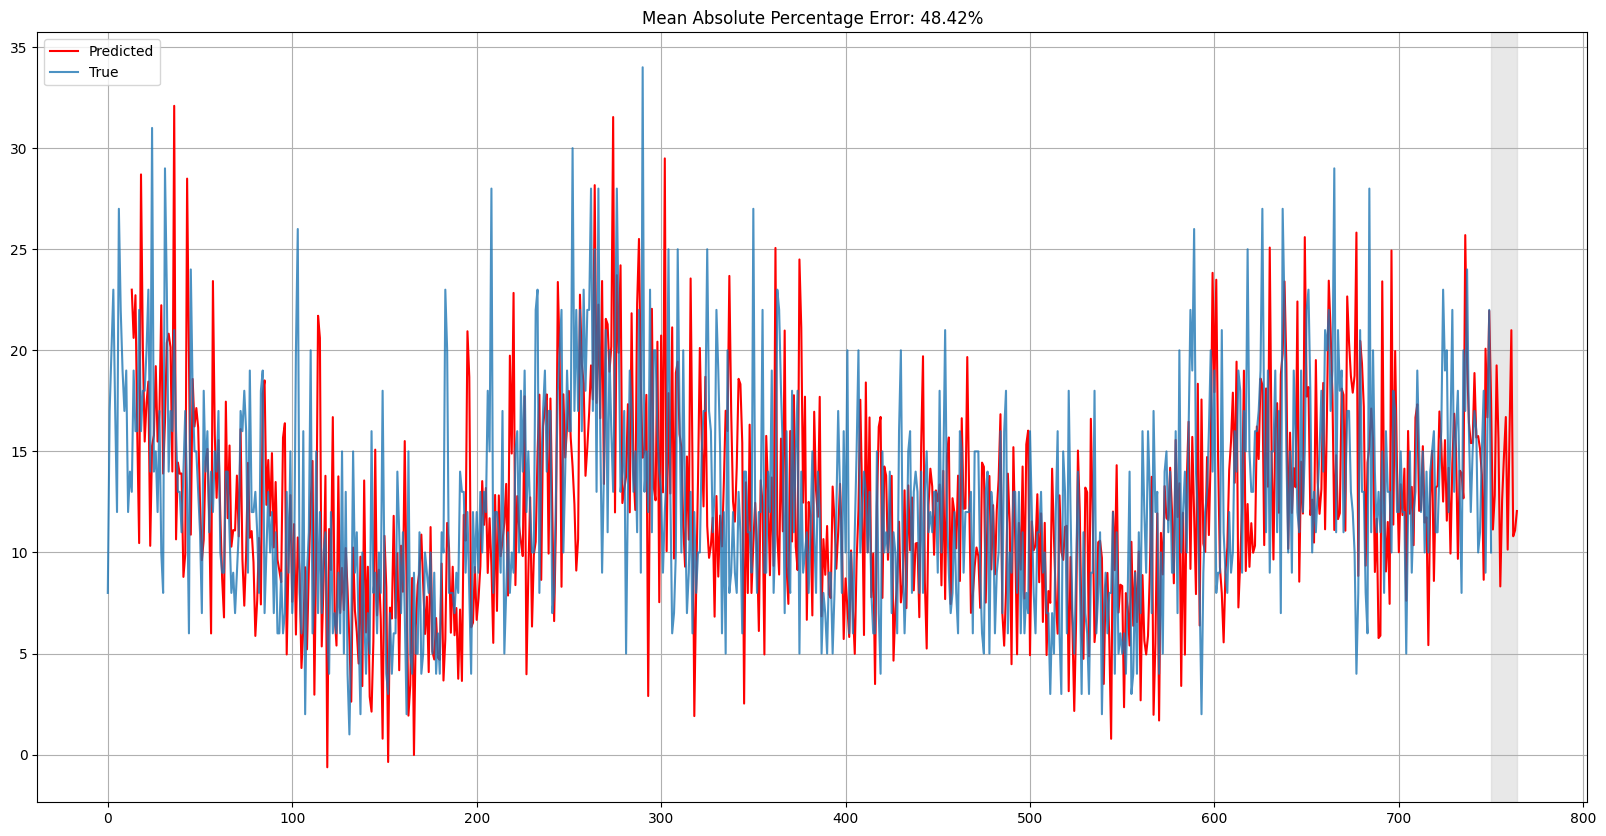

In [195]:
plot_predictions(my_data[['Views']], best_model2, 14)

Ошибка на валидации получилась большой(. Возможно все-таки стоило перебирать те параметры, которые я увидел из графика